In [22]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pandas as pd
import duckdb

In [2]:
# Load CSVs
customers = pd.read_csv('../data/raw/DS_Case_Study2_data/customers_ng.csv')
accounts = pd.read_csv('../data/raw/DS_Case_Study2_data/accounts_ng.csv')
transactions = pd.read_csv('../data/raw/DS_Case_Study2_data/transactions_ng.csv')

# Create SQLite DB
db_path = "../data/fraud_poc.db"
conn = sqlite3.connect(db_path)

# Save as tables
customers.to_sql("customers", conn, if_exists="replace", index=False)
accounts.to_sql("accounts", conn, if_exists="replace", index=False)
transactions.to_sql("transactions", conn, if_exists="replace", index=False)


db_path

'../data/fraud_poc.db'

In [3]:
# display the tables

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)


tables

,name
0,customers
1,accounts
2,transactions


In [4]:
# print the first 5 rows of the customers table
customers_head = pd.read_sql_query("SELECT * FROM customers LIMIT 5;", conn)
accounts_head = pd.read_sql_query("SELECT * FROM accounts LIMIT 5;", conn)
transactions_head = pd.read_sql_query("SELECT * FROM transactions LIMIT 5;", conn)


customers_head, accounts_head, transactions_head

(  customer_id customer_segment
 0   CUST_0001         Personal
 1   CUST_0002         Personal
 2   CUST_0003        Corporate
 3   CUST_0004        Corporate
 4   CUST_0005         Personal,
   account_id account_type customer_id
 0  ACC_00001      Savings   CUST_0924
 1  ACC_00002      Savings   CUST_1821
 2  ACC_00003      Current   CUST_0512
 3  ACC_00004       Salary   CUST_1135
 4  ACC_00005      Savings   CUST_1053,
   transaction_id account_id transaction_datetime transaction_channel  \
 0     TXN_000001  ACC_03664  2025-08-27 21:46:32                 POS   
 1     TXN_000002  ACC_04332  2025-09-27 19:29:47                USSD   
 2     TXN_000003  ACC_03483  2025-08-06 00:56:03                 Web   
 3     TXN_000004  ACC_04321  2025-09-03 04:21:20                 Web   
 4     TXN_000005  ACC_03388  2025-09-22 18:34:38                 POS   
 
      amount merchant_category transaction_location  is_fraud  
 0  19668.61      Fuel Station               Kaduna         0  
 1  

In [4]:
# merge the tables together  using sql and save it as csv
# SQL join to merge customers + accounts + transactions
query = """
SELECT
    t.transaction_id,
    t.account_id,
    a.customer_id,
    c.customer_segment,
    t.transaction_datetime,
    t.transaction_channel,
    t.amount,
    t.merchant_category,
    t.transaction_location,
    t.is_fraud,
    a.account_type
FROM transactions t
LEFT JOIN accounts a ON t.account_id = a.account_id
LEFT JOIN customers c ON a.customer_id = c.customer_id;
"""

merged_df = pd.read_sql_query(query, conn)


In [5]:
merged_df.to_csv("../data/processed/merged_customer_data.csv")

In [6]:
# Engineering Features for Fraud Detection
df = merged_df.copy()

In [7]:
# checking the data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   transaction_id        180000 non-null  object 
 1   account_id            180000 non-null  object 
 2   customer_id           180000 non-null  object 
 3   customer_segment      180000 non-null  object 
 4   transaction_datetime  180000 non-null  object 
 5   transaction_channel   180000 non-null  object 
 6   amount                180000 non-null  float64
 7   merchant_category     180000 non-null  object 
 8   transaction_location  180000 non-null  object 
 9   is_fraud              180000 non-null  int64  
 10  account_type          180000 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 15.1+ MB


In [8]:
df.dtypes

transaction_id           object
account_id               object
customer_id              object
customer_segment         object
transaction_datetime     object
transaction_channel      object
amount                  float64
merchant_category        object
transaction_location     object
is_fraud                  int64
account_type             object
dtype: object

In [9]:
df.head()

,transaction_id,account_id,customer_id,customer_segment,transaction_datetime,transaction_channel,amount,merchant_category,transaction_location,is_fraud,account_type
0,TXN_000001,ACC_03664,CUST_1688,Personal,2025-08-27 21:46:32,POS,19668.61,Fuel Station,Kaduna,0,Savings
1,TXN_000002,ACC_04332,CUST_0006,Personal,2025-09-27 19:29:47,USSD,43698.55,Bill Payment,Lagos,0,Salary
2,TXN_000003,ACC_03483,CUST_0812,Personal,2025-08-06 00:56:03,Web,23839.03,Bill Payment,Abuja,0,Savings
3,TXN_000004,ACC_04321,CUST_1048,Corporate,2025-09-03 04:21:20,Web,19447.08,Bill Payment,Lagos,0,Current
4,TXN_000005,ACC_03388,CUST_1329,SME,2025-09-22 18:34:38,POS,46728.97,POS Payment,Onitsha,0,Savings


In [ ]:
# Connect DuckDB - an in-process SQL OLAP database management system( justl like sqlite but more powerful for analytical queries)
con = duckdb.connect()

# Register tables
con.register("customers", customers)
con.register("accounts", accounts)
con.register("transactions", transactions)

query = """
WITH base AS (
    SELECT
        t.transaction_id,
        t.account_id,
        a.customer_id,
        CAST(t.transaction_datetime AS TIMESTAMP) AS transaction_datetime,
        t.amount,
        t.is_fraud,

        -- weekend flag
        CASE 
            WHEN date_part('dow', CAST(t.transaction_datetime AS TIMESTAMP)) IN (0, 6)
            THEN 1 ELSE 0 
        END AS is_weekend,

        -- night flag
        CASE
            WHEN date_part('hour', CAST(t.transaction_datetime AS TIMESTAMP)) >= 20
              OR date_part('hour', CAST(t.transaction_datetime AS TIMESTAMP)) < 6
            THEN 1 ELSE 0 
        END AS is_night
    FROM transactions t
    LEFT JOIN accounts a ON t.account_id = a.account_id
)

SELECT
    *,
    LAG(transaction_datetime) OVER (
        PARTITION BY customer_id ORDER BY transaction_datetime
    ) AS prev_txn_time,

    DATE_DIFF(
        'hour',
        LAG(transaction_datetime) OVER (PARTITION BY customer_id ORDER BY transaction_datetime),
        transaction_datetime
    ) AS time_since_last_transaction,

    AVG(amount) OVER (
        PARTITION BY account_id
        ORDER BY transaction_datetime
        RANGE BETWEEN INTERVAL 7 DAY PRECEDING AND CURRENT ROW
    ) AS avg_amount_7d,

    COUNT(*) OVER (
        PARTITION BY account_id
        ORDER BY transaction_datetime
        RANGE BETWEEN INTERVAL 7 DAY PRECEDING AND CURRENT ROW
    ) AS count_transactions_7d

FROM base
ORDER BY customer_id, transaction_datetime;
"""

df_anomaly = con.execute(query).df()
df_anomaly.head()


,transaction_id,account_id,customer_id,transaction_datetime,amount,is_fraud,is_weekend,is_night,prev_txn_time,time_since_last_transaction,avg_amount_7d,count_transactions_7d
0,TXN_163851,ACC_03070,CUST_0001,2025-08-01 06:45:20,9641.65,0,0,0,NaT,<NA>,9641.650000,1
1,TXN_026097,ACC_04410,CUST_0001,2025-08-01 09:10:04,9382.34,0,0,0,2025-08-01 06:45:20,3,9382.340000,1
2,TXN_060803,ACC_03070,CUST_0001,2025-08-01 19:45:13,4707.01,0,0,0,2025-08-01 09:10:04,10,7174.330000,2
3,TXN_025799,ACC_04410,CUST_0001,2025-08-02 23:41:55,10676.77,0,1,1,2025-08-01 19:45:13,28,10029.555000,2
4,TXN_151201,ACC_03070,CUST_0001,2025-08-03 03:29:39,4438.37,0,1,1,2025-08-02 23:41:55,4,6262.343333,3


In [49]:
df_anomaly.to_csv("../data/processed/fraud_detection_features.csv", index=False)

In [50]:
df_orig = pd.read_csv("../data/processed/merged_customer_data.csv")
df_orig.head()

,Unnamed: 0,transaction_id,account_id,customer_id,customer_segment,transaction_datetime,transaction_channel,amount,merchant_category,transaction_location,is_fraud,account_type
0,0,TXN_000001,ACC_03664,CUST_1688,Personal,2025-08-27 21:46:32,POS,19668.61,Fuel Station,Kaduna,0,Savings
1,1,TXN_000002,ACC_04332,CUST_0006,Personal,2025-09-27 19:29:47,USSD,43698.55,Bill Payment,Lagos,0,Salary
2,2,TXN_000003,ACC_03483,CUST_0812,Personal,2025-08-06 00:56:03,Web,23839.03,Bill Payment,Abuja,0,Savings
3,3,TXN_000004,ACC_04321,CUST_1048,Corporate,2025-09-03 04:21:20,Web,19447.08,Bill Payment,Lagos,0,Current
4,4,TXN_000005,ACC_03388,CUST_1329,SME,2025-09-22 18:34:38,POS,46728.97,POS Payment,Onitsha,0,Savings


In [51]:
# drop is_fraud column from anomaly df
df_anomaly = df_anomaly.drop(columns=['is_fraud'])

In [55]:
df_orig["transaction_datetime"] = pd.to_datetime(df_orig["transaction_datetime"])
df_anomaly["transaction_datetime"] = pd.to_datetime(df_anomaly["transaction_datetime"])

In [57]:
# let merge the two dataframes to include all features
# Merge on transaction_id (primary key)
df_final = df_orig.merge(
    df_anomaly.drop(columns=["amount", "account_id", "customer_id", "transaction_datetime"]),
    on="transaction_id",
    how="left"
)

### Exploratory Analysis

In [23]:
# EDA basic dataset (no rolling windows yet for speed)
df = con.execute("""
SELECT
    t.amount,
    CAST(t.transaction_datetime AS TIMESTAMP) AS transaction_datetime,
    date_part('hour', CAST(t.transaction_datetime AS TIMESTAMP)) AS hour,
    date_part('dow', CAST(t.transaction_datetime AS TIMESTAMP)) AS weekday,
    t.is_fraud
FROM transactions t
""").df()

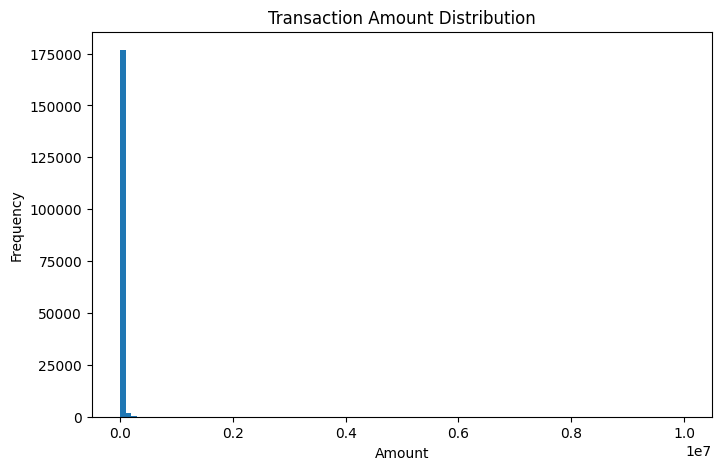

In [25]:
# Plot 1: Amount distribution
plt.figure(figsize=(8,5))
plt.hist(df["amount"], bins=100)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

* The amount distribution is right-skewed with a long tail, indicating that most transactions are of lower amounts, while a few high-value transactions exist. 
* Thier may be a need to cary log transformation on this feature

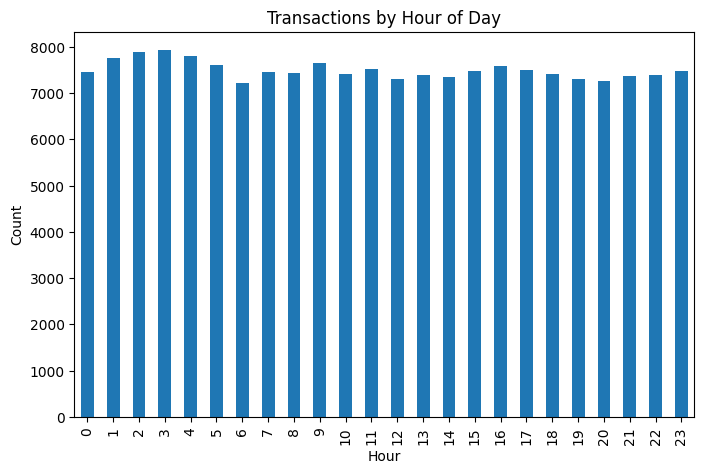

In [26]:
# Plot 2: Transactions by hour
plt.figure(figsize=(8,5))
df["hour"].value_counts().sort_index().plot(kind="bar")
plt.title("Transactions by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

Transaction volume is very stable across all 24 hours. No specific spike at night or daytime.

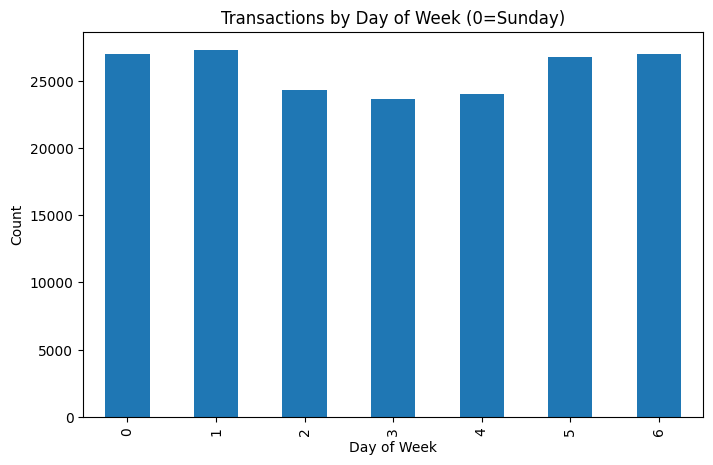

In [27]:
# Plot 3: Transactions by weekday
plt.figure(figsize=(8,5))
df["weekday"].value_counts().sort_index().plot(kind="bar")
plt.title("Transactions by Day of Week (0=Sunday)")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.show()

Distribution across days is also stable. Slightly higher volumes on Monday, Friday, Saturday, Sunday.

In [28]:
df.head()

,amount,transaction_datetime,hour,weekday,is_fraud
0,19668.61,2025-08-27 21:46:32,21,3,0
1,43698.55,2025-09-27 19:29:47,19,6,0
2,23839.03,2025-08-06 00:56:03,0,3,0
3,19447.08,2025-09-03 04:21:20,4,3,0
4,46728.97,2025-09-22 18:34:38,18,1,0


In [29]:
df = merged_df.copy()

In [30]:
df.head()

,transaction_id,account_id,customer_id,customer_segment,transaction_datetime,transaction_channel,amount,merchant_category,transaction_location,is_fraud,account_type
0,TXN_000001,ACC_03664,CUST_1688,Personal,2025-08-27 21:46:32,POS,19668.61,Fuel Station,Kaduna,0,Savings
1,TXN_000002,ACC_04332,CUST_0006,Personal,2025-09-27 19:29:47,USSD,43698.55,Bill Payment,Lagos,0,Salary
2,TXN_000003,ACC_03483,CUST_0812,Personal,2025-08-06 00:56:03,Web,23839.03,Bill Payment,Abuja,0,Savings
3,TXN_000004,ACC_04321,CUST_1048,Corporate,2025-09-03 04:21:20,Web,19447.08,Bill Payment,Lagos,0,Current
4,TXN_000005,ACC_03388,CUST_1329,SME,2025-09-22 18:34:38,POS,46728.97,POS Payment,Onitsha,0,Savings


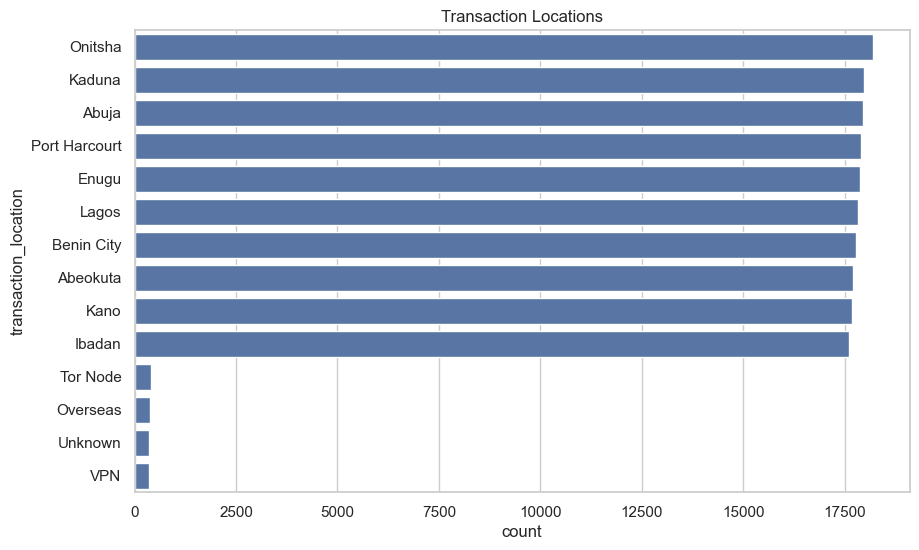

In [47]:
# transaction_location plot
plt.figure(figsize=(10,6))
sns.countplot(y='transaction_location', data=df, order=df['transaction_location'].value_counts().index)
plt.title('Transaction Locations')
plt.show()

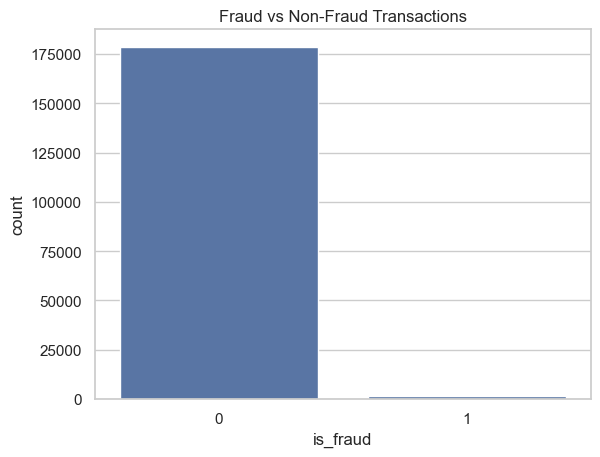

In [40]:
sns.set(style="whitegrid")
sns.countplot(x='is_fraud', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

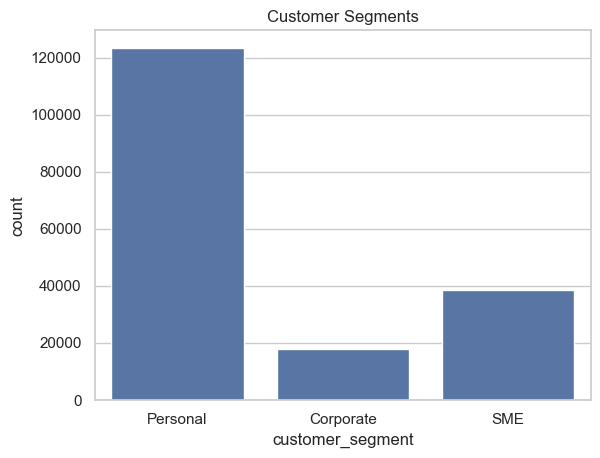

In [41]:
# visualizing customer segments
sns.set(style="whitegrid")
sns.countplot(x='customer_segment', data=df)
plt.title('Customer Segments')
plt.show()

We have more customers with personal accounts than  the corporate and sme segments combined.

In [32]:
df.shape

(180000, 11)

In [34]:
df.describe(include="object")

,transaction_id,account_id,customer_id,customer_segment,transaction_datetime,transaction_channel,merchant_category,transaction_location,account_type
count,180000,180000,180000,180000,180000,180000,180000,180000,180000
unique,180000,4500,1795,3,176872,5,16,14,4
top,TXN_179984,ACC_01016,CUST_0708,Personal,2025-08-13 14:09:38,USSD,POS Payment,Onitsha,Savings
freq,1,65,339,123464,3,36389,15042,18195,90212


In [35]:
df.columns

Index(['transaction_id', 'account_id', 'customer_id', 'customer_segment',
       'transaction_datetime', 'transaction_channel', 'amount',
       'merchant_category', 'transaction_location', 'is_fraud',
       'account_type'],
      dtype='object')

In [37]:
df.is_fraud.value_counts()

is_fraud
0    178500
1      1500
Name: count, dtype: int64

In [38]:
df.duplicated().sum()

np.int64(0)

The fraud rate is 0.84 percent, indicating a significant class imbalance in the dataset. thier will a need to carry out smote on the dataset

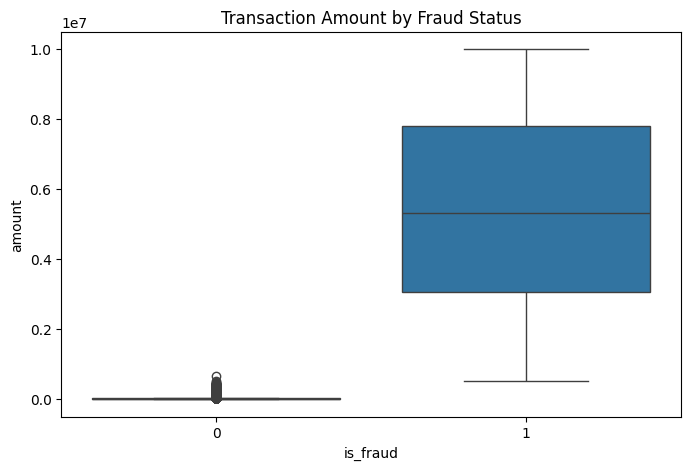

In [ ]:
# relationship between amount and is_fraud
plt.figure(figsize=(8,5))
sns.boxplot(x='is_fraud', y='amount', data=df)
plt.title('Transaction Amount by Fraud Status')
plt.show()
